In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import ndimage, misc
import numpy as np
import math

(375, 500, 3)
(66, 143, 3)


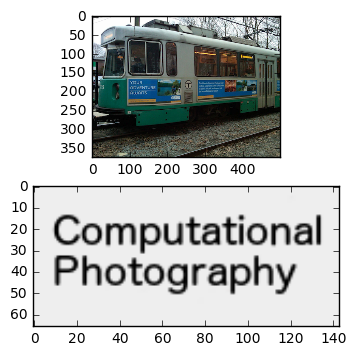

In [3]:
greenImage = ndimage.imread('./green.png')
posterImage = ndimage.imread('./poster.png')[:, :, :3]

H = np.array([[ 0.8025, 0.0116, -78.2148],
              [-0.0058, 0.8346, -141.3292], 
              [-0.0006, -0.0002, 1. ]])

print greenImage.shape
print posterImage.shape

subplot(2, 1, 1)
imshow(greenImage)
subplot(2, 1, 2)
imshow(posterImage)

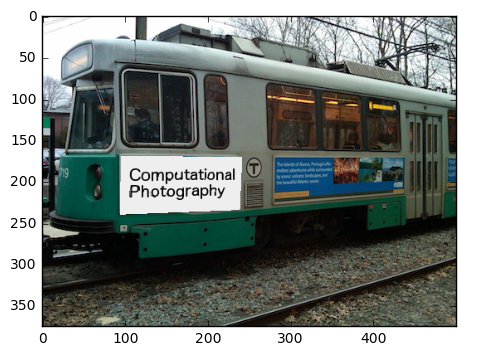

In [4]:
def homogenousCoords(image):
    fstCoords = np.arange(0, image.shape[0])
    sndCoords = np.arange(0, image.shape[1])
    zOnes   = np.ones(image.shape[0] * image.shape[1])
    return np.array([np.tile(fstCoords, image.shape[1]), np.repeat(sndCoords, image.shape[0]), zOnes]).astype(int).T
    
def computeHomography(image, homographyMatrix):
    coords = homogenousCoords(image)
    
    appliedHomography = np.apply_along_axis(lambda point: np.dot(homographyMatrix, point), 1, coords)
    appliedHomography[:, 0] /= appliedHomography[:, 2]
    appliedHomography[:, 1] /= appliedHomography[:, 2]
            
    return coords[:, :2], appliedHomography[:, :2]

def naiveBlend(image, projected):
    return image[projected[1], projected[0]]

def blendHomography(blendedImage, targetImage, homographyMatrix, roundHomography = True, blendFn = naiveBlend):
    coords, homography = computeHomography(targetImage, homographyMatrix)
    result = targetImage.copy()
    if roundHomography:
        homography = np.round(homography).astype(int)
    
    valid = np.logical_and(
        np.logical_and(homography[:, 0] >= 0, homography[:, 0] < blendedImage.shape[1]),
        np.logical_and(homography[:, 1] >= 0, homography[:, 1] < blendedImage.shape[0])
    )
    
    targetCoords = coords[valid]
    blendCoords = homography[valid]
    
    for i in range(targetCoords.shape[0]):
        if targetCoords[i][1] >= result.shape[0]:
            continue
        if targetCoords[i][0] >= result.shape[1]:
            continue
        
        result[targetCoords[i][1], targetCoords[i][0], :] = blendFn(blendedImage, blendCoords[i])
        
    return result
    

blended = blendHomography(posterImage, greenImage, H)

imshow(blended)
misc.imsave('green-poster-applied.png', blended)
    
    

In [5]:
def bilinearBlend(image, blendCoords):
    x, y = blendCoords
    yf, yc = int(math.floor(y)), int(math.ceil(y))
    xf, xc = int(math.floor(x)), int(math.ceil(x))
    def pixel(y, x, i):
        if x == image.shape[1]:
            x = x - 1
        if y == image.shape[0]:
            y = y - 1
        return image[y, x, i]
    
    samples = lambda i: np.array([[pixel(yf, xf, i), pixel(yc, xf, i)],
                                  [pixel(yf, xc, i), pixel(yc, xc, i)]])
    
    xOffsets = np.array([xc - x, x - xf])
    yOffsets = np.array([[yc - y],
                         [y - yf]])
    normalizingTerm = (1 / ((yc - yf) * (xc - xf)))
    
    red = normalizingTerm * np.dot(np.dot(xOffsets, samples(0)), yOffsets)[0]
    green = normalizingTerm * np.dot(np.dot(xOffsets, samples(1)), yOffsets)[0]
    blue = normalizingTerm * np.dot(np.dot(xOffsets, samples(2)), yOffsets)[0]
        
    return np.array([red, green, blue]).astype(int)
                       
#blendedBilinear = blendHomography(posterImage, greenImage, H, False, bilinearBlend)

#imshow(blendedBilinear)
#misc.imsave('green-poster-applied-bi.png', blended)

In [6]:
def findHomographyMatrix(pointPairs):
    coeffMatrix = []
    
    for index in range(len(pointPairs)):
        xBase = pointPairs[index][0][1]
        yBase = pointPairs[index][0][0]
        xProj = pointPairs[index][1][1]
        yProj = pointPairs[index][1][0]
        
        coeffMatrix.append([yBase, 
                             xBase, 
                             1, 0, 0, 0, 
                             -yBase * yProj,
                             -xBase * yProj,
                             -yProj])
        coeffMatrix.append([0, 0, 0,
                             yBase,
                             xBase,
                             1,
                             -yBase * xProj,
                             -xBase * xProj,
                             -xProj])
        
        svdResult = np.linalg.svd(np.array(coeffMatrix))[2][-1]
        result = array([[svdResult[0], svdResult[1], svdResult[2]], 
                        [svdResult[3], svdResult[4], svdResult[5]], 
                        [svdResult[6], svdResult[7], svdResult[8]]])
        
    return result

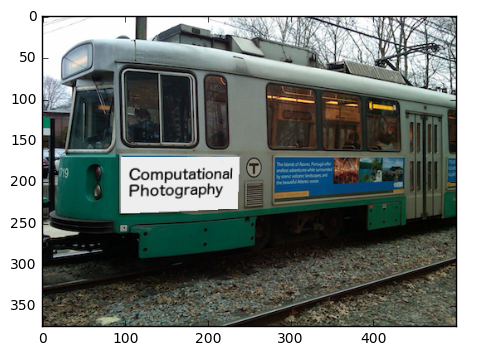

In [7]:
posterH, posterW = posterImage.shape[:2]
projPosterPts = [[0, 0, 1],
                 [posterW, 0, 1],
                 [posterW, posterH, 1],
                 [0, posterH, 1]]

basePosterPts = [[95, 170, 1],
                 [238, 171, 1],
                 [235, 233, 1],
                 [94, 239, 1]]

calculatedPosterH = findHomographyMatrix(zip(basePosterPts, projPosterPts))
blendedCalcBilinear = blendHomography(posterImage, greenImage, calculatedPosterH, False, bilinearBlend)

imshow(blendedCalcBilinear)
misc.imsave('green-poster-applied-calc.png', blended)

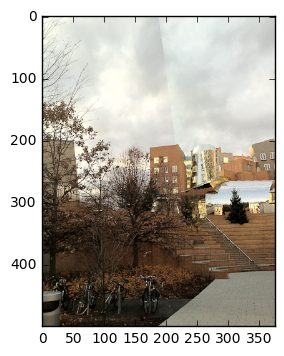

In [8]:
stataFstImage = imread('./pano/stata-1.png')
stataSndImage = imread('./pano/stata-2.png')

stataBasePoints = [np.array([218, 209, 1]), 
                   np.array([300, 425, 1]), 
                   np.array([337, 209, 1]), 
                   np.array([336, 396, 1])]
stataProjPoints = [np.array([4, 232, 1]), 
                   np.array([62, 465, 1]), 
                   np.array([125, 247, 1]), 
                   np.array([102, 433, 1])]

calculatedStataH = findHomographyMatrix(zip(stataBasePoints, stataProjPoints))

blendedStataNaive = blendHomography(stataSndImage, stataFstImage, calculatedStataH)

imshow(blendedStataNaive)
imsave('stata-applied-naive.png', blendedStataNaive)

/Users/Killavus/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Killavus/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Killavus/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


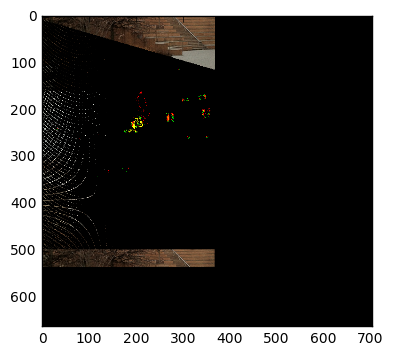

In [33]:
def homogenousCoords(image):
    fstCoords = np.arange(0, image.shape[0])
    sndCoords = np.arange(0, image.shape[1])
    zOnes   = np.ones(image.shape[0] * image.shape[1])
    return np.array([np.repeat(sndCoords, image.shape[0]), np.tile(fstCoords, image.shape[1]), zOnes]).astype(int).T

def computeHomography(image, homographyMatrix):
    coords = homogenousCoords(image)
    
    appliedHomography = np.apply_along_axis(lambda point: np.dot(homographyMatrix, point), 1, coords)
    appliedHomography[:, 0] /= appliedHomography[:, 2]
    appliedHomography[:, 1] /= appliedHomography[:, 2]
            
    return coords[:, :2], appliedHomography[:, :2]

def stitchedPanorama(projectedImage, flatImage, basePoints, projPoints):
    homographyM = findHomographyMatrix(zip(basePoints, projPoints))
    inverseHomographyM = np.linalg.inv(homographyM)
    coords, inverseHomography = computeHomography(projectedImage, inverseHomographyM)
    
    maxX, maxY = np.amax(inverseHomography, 0)
    minX, minY = np.amin(inverseHomography, 0)
    maxX, maxY = math.ceil(max(maxX, flatImage.shape[1])), math.ceil(max(maxY, flatImage.shape[0]))
    minX, minY = math.floor(min(minX, 0)), math.floor(min(minY, 0))
    
    boundingBox = np.empty((maxY - minY, maxX - minX, 3))
    boxCoords, homography = computeHomography(boundingBox, homographyM)
    
    validProjected = np.logical_and(
        np.logical_and(homography[:, 0] >= 0, homography[:, 0] <= projectedImage.shape[1] - 1),
        np.logical_and(homography[:, 1] >= 0, homography[:, 1] <= projectedImage.shape[0] - 1)
    )
    
    validFlat = np.logical_and(
        np.logical_and((homography[:, 0] + minX) >= 0, (homography[:, 0] + minX) <= flatImage.shape[1] - 1),
        np.logical_and((homography[:, 1] + minY) >= 0, (homography[:, 1] + minY) <= flatImage.shape[0] - 1)
    )
    
    flatCoords = boxCoords[validFlat]
    projCoords = homography[validProjected]
    
    for i in range(len(flatCoords)):
        if boxCoords[i][1] + minY >= flatImage.shape[1]:
            continue
        if boxCoords[i][0] + minY >= flatImage.shape[0]:
            continue
            
        boundingBox[boxCoords[i][1], boxCoords[i][0]] = flatImage[boxCoords[i][1] + minY, boxCoords[i][0] + minX]
        
    for i in range(len(projCoords)):
        boundingBox[projCoords[i][1], projCoords[i][0]] = bilinearBlend(projectedImage, projCoords[i])
    
    return boundingBox
    
    
stitchedStata = stitchedPanorama(stataSndImage, stataFstImage, stataBasePoints, stataProjPoints)
imshow(stitchedStata)
    